## Problem Statement

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.). 



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost. 
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models. 
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing necessary libraries

In [ ]:
# nb_black is simple extension for Jupyter Notebook used to beautify Python code automatically using Black
!pip install nb_black

%load_ext nb_black

In [ ]:
# imblearn is a toolbox for imbalanced dataset in machine learning
!pip install imblearn

In [ ]:
# Installing necessary libraries
!pip install pandas numpy seaborn xgboost

In [4]:
# Libraries used for reading and manipulating the data
import pandas as pd
import numpy as np

# Libraries for data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# To be used for missing value imputation
from sklearn.impute import SimpleImputer

# Libraries to help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# These libraries are used to obtain different metric scores/split the data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
)

# These libraries are used to oversample and undersample the data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Library used to tune the model and perform hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# Libraries used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# Libraries used to perform statistical functions
import scipy.stats as stats

# Libraries used for creating pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# The Pandas library used to define the maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# The Pandas library used to supress the scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# Library used to supress warnings
import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

## Loading the dataset

In [5]:
# Loading the dataset
train = pd.read_csv("Train.csv")

<IPython.core.display.Javascript object>

In [6]:
# number of rows and columns in the data
train.shape

(20000, 41)

<IPython.core.display.Javascript object>

There are 20,000 rows and 41 attributes in the dataset.

## Data Overview

- Observations
- Sanity checks

In [7]:
df = train.copy()

<IPython.core.display.Javascript object>

In [8]:
# let's view the first and last 5 rows of the data
df.head(-10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
2,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0
3,1.618,1.888,7.046,-1.147,0.083,-1.530,0.207,-2.494,0.345,2.119,-3.053,0.460,2.705,-0.636,-0.454,-3.174,-3.404,-1.282,1.582,-1.952,-3.517,-1.206,-5.628,-1.818,2.124,5.295,4.748,-2.309,-3.963,-6.029,4.949,-3.584,-2.577,1.364,0.623,5.550,-1.527,0.139,3.101,-1.277,0
4,-0.111,3.872,-3.758,-2.983,3.793,0.545,0.205,4.849,-1.855,-6.220,1.998,4.724,0.709,-1.989,-2.633,4.184,2.245,3.734,-6.313,-5.380,-0.887,2.062,9.446,4.490,-3.945,4.582,-8.780,-3.383,5.107,6.788,2.044,8.266,6.629,-10.069,1.223,-3.230,1.687,-2.164,-3.645,6.510,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19985,7.451,-1.020,5.852,-5.451,-2.372,-2.413,0.980,0.585,1.320,0.980,-3.087,2.337,5.364,1.747,0.563,-2.258,-3.453,-0.552,-1.480,0.084,-5.406,1.625,-1.809,-6.522,5.047,1.535,9.584,-3.723,-5.486,-6.929,4.885,-6.867,-7.583,-0.158,-0.039,7.180,0.289,-6.060,2.006,1.872,0
19986,-3.006,0.933,3.567,3.213,2.224,-5.212,-1.790,4.132,-1.758,-0.286,-8.657,5.114,1.213,-0.466,-4.103,-2.051,5.072,1.984,2.463,2.962,-4.985,2.205,4.436,8.047,-0.466,3.051,-6.446,-0.221,-4.918,-0.818,3.426,8.867,-2.723,-0.911,3.881,3.939,0.306,-4.202,0.414,-1.888,0
19987,0.641,2.793,2.112,-4.162,1.259,-0.256,-0.705,0.930,1.735,-5.704,0.324,3.253,6.095,-1.680,-5.070,-0.573,-0.676,2.992,-6.064,-1.761,-4.146,0.269,1.888,-4.820,-0.575,6.031,-2.282,-5.290,2.645,1.518,0.642,-2.986,1.859,-6.530,-0.792,1.230,2.687,-4.442,0.501,4.801,0
19988,-2.607,6.044,5.009,5.768,2.959,-4.042,0.014,1.657,-1.875,-1.021,-6.044,4.411,-2.307,-3.710,-0.838,-2.116,5.374,-1.182,5.545,-0.594,-3.318,-0.206,0.094,9.031,-1.237,6.956,-7.792,0.746,-2.091,-1.113,3.066,5.974,-0.381,0.266,3.919,-0.194,-1.498,2.149,-0.168,-1.840,0


<IPython.core.display.Javascript object>

In [9]:
# checking for the data types of the columns in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

<IPython.core.display.Javascript object>

- All attributes except for the "Target" attribute are of float type.
- There are 18 missing values each for both attribute "V1" and "V2".

In [10]:
# checking for duplicate values in the data
df.duplicated().sum()

0

<IPython.core.display.Javascript object>

The dataset has no duplicate values.

In [11]:
# viewing the statistical summary of the numerical columns in the data
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
count,19982.000,19982.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000
mean,-0.272,0.440,2.485,-0.083,-0.054,-0.995,-0.879,-0.548,-0.017,-0.013,-1.895,1.605,1.580,-0.951,-2.415,-2.925,-0.134,1.189,1.182,0.024,-3.611,0.952,-0.366,1.134,-0.002,1.874,-0.612,-0.883,-0.986,-0.016,0.487,0.304,0.050,-0.463,2.230,1.515,0.011,-0.344,0.891,-0.876,0.056
std,3.442,3.151,3.389,3.432,2.105,2.041,1.762,3.296,2.161,2.193,3.124,2.930,2.875,1.790,3.355,4.222,3.345,2.592,3.397,3.669,3.568,1.652,4.032,3.912,2.017,3.435,4.369,1.918,2.684,3.005,3.461,5.500,3.575,3.184,2.937,3.801,1.788,3.948,1.753,3.012,0.229
min,-11.876,-12.320,-10.708,-15.082,-8.603,-10.227,-7.950,-15.658,-8.596,-9.854,-14.832,-12.948,-13.228,-7.739,-16.417,-20.374,-14.091,-11.644,-13.492,-13.923,-17.956,-10.122,-14.866,-16.387,-8.228,-11.834,-14.905,-9.269,-12.579,-14.796,-13.723,-19.877,-16.898,-17.985,-15.350,-14.833,-5.478,-17.375,-6.439,-11.024,0.000
25%,-2.737,-1.641,0.207,-2.348,-1.536,-2.347,-2.031,-2.643,-1.495,-1.411,-3.922,-0.397,-0.224,-2.171,-4.415,-5.634,-2.216,-0.404,-1.050,-2.433,-5.930,-0.118,-3.099,-1.468,-1.365,-0.338,-3.652,-2.171,-2.787,-1.867,-1.818,-3.420,-2.243,-2.137,0.336,-0.944,-1.256,-2.988,-0.272,-2.940,0.000
50%,-0.748,0.472,2.256,-0.135,-0.102,-1.001,-0.917,-0.389,-0.068,0.101,-1.921,1.508,1.637,-0.957,-2.383,-2.683,-0.015,0.883,1.279,0.033,-3.533,0.975,-0.262,0.969,0.025,1.951,-0.885,-0.891,-1.176,0.184,0.490,0.052,-0.066,-0.255,2.099,1.567,-0.128,-0.317,0.919,-0.921,0.000
75%,1.840,2.544,4.566,2.131,1.340,0.380,0.224,1.723,1.409,1.477,0.119,3.571,3.460,0.271,-0.359,-0.095,2.069,2.572,3.493,2.512,-1.266,2.026,2.452,3.546,1.397,4.130,2.189,0.376,0.630,2.036,2.731,3.762,2.255,1.437,4.064,3.984,1.176,2.279,2.058,1.120,0.000
max,15.493,13.089,17.091,13.236,8.134,6.976,8.006,11.679,8.138,8.108,11.826,15.081,15.420,5.671,12.246,13.583,16.756,13.180,13.238,16.052,13.840,7.410,14.459,17.163,8.223,16.836,17.560,6.528,10.722,12.506,17.255,23.633,16.692,14.358,15.291,19.330,7.467,15.290,7.760,10.654,1.000


<IPython.core.display.Javascript object>

The spread of attributes will be explored further when we perform the analysis.

In [12]:
# checking for number of unique values in each column
df.nunique()

V1        19982
V2        19982
V3        20000
V4        20000
V5        20000
V6        20000
V7        20000
V8        20000
V9        20000
V10       20000
V11       20000
V12       20000
V13       20000
V14       20000
V15       20000
V16       20000
V17       20000
V18       20000
V19       20000
V20       20000
V21       20000
V22       20000
V23       20000
V24       20000
V25       20000
V26       20000
V27       20000
V28       20000
V29       20000
V30       20000
V31       20000
V32       20000
V33       20000
V34       20000
V35       20000
V36       20000
V37       20000
V38       20000
V39       20000
V40       20000
Target        2
dtype: int64

<IPython.core.display.Javascript object>

All attributes except "Target" have all unique values

## Exploratory Data Analysis (EDA)

### Plotting histograms and boxplots for all the variables

In [13]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

### Plotting all the features at one go

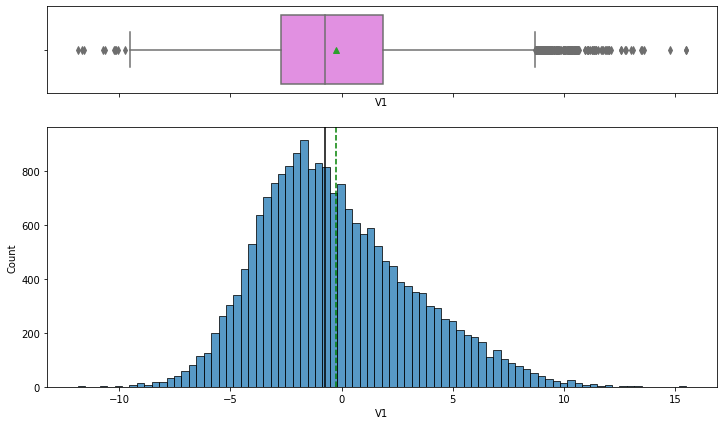

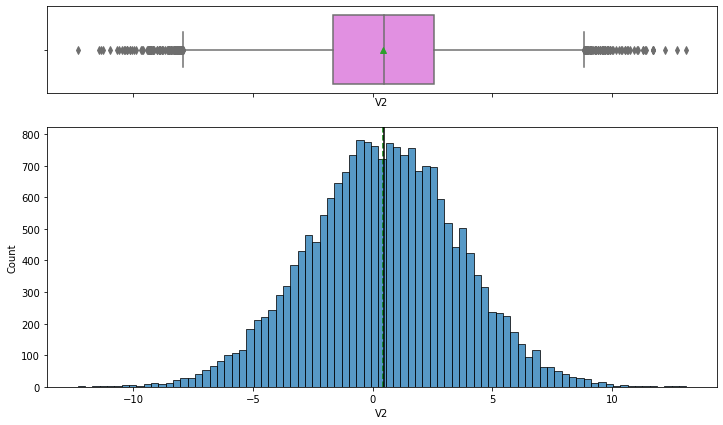

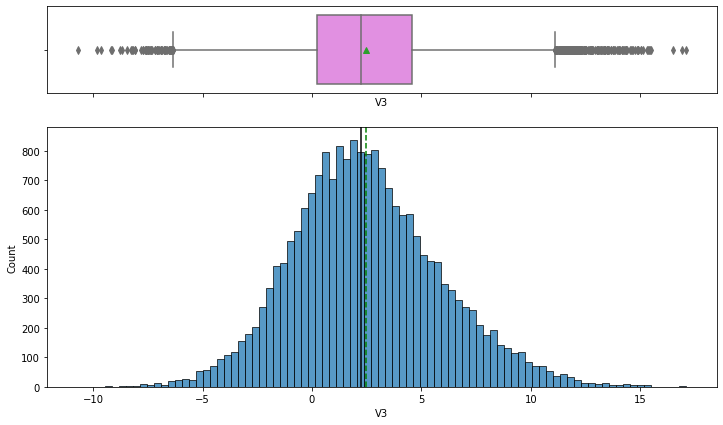

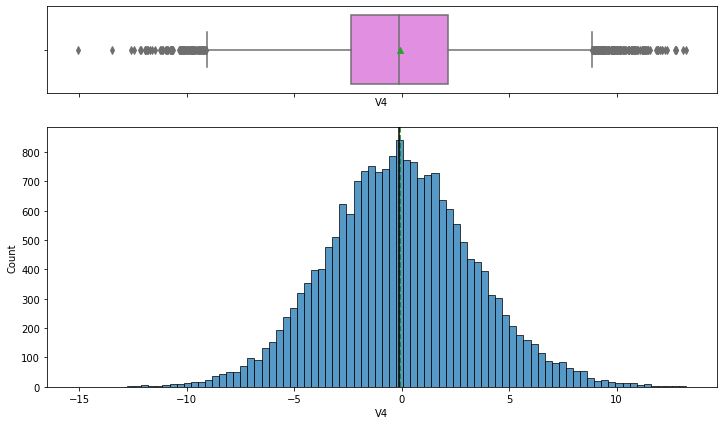

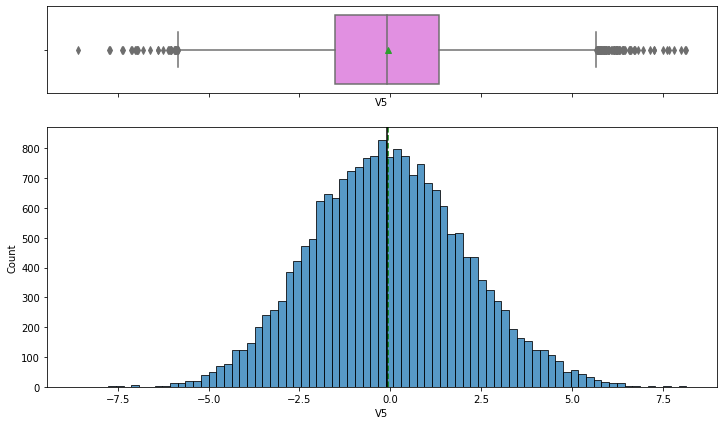

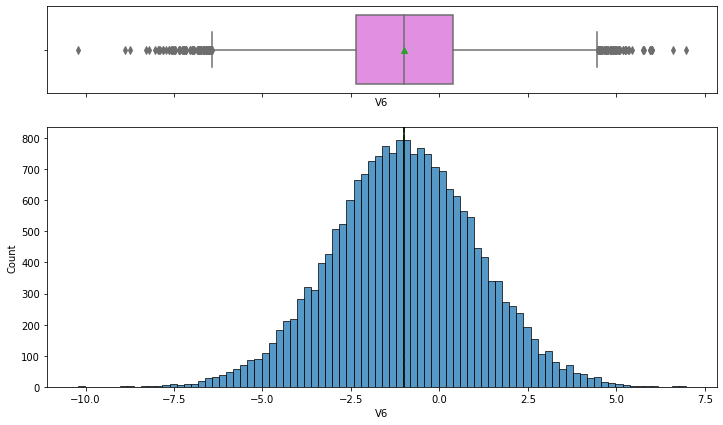

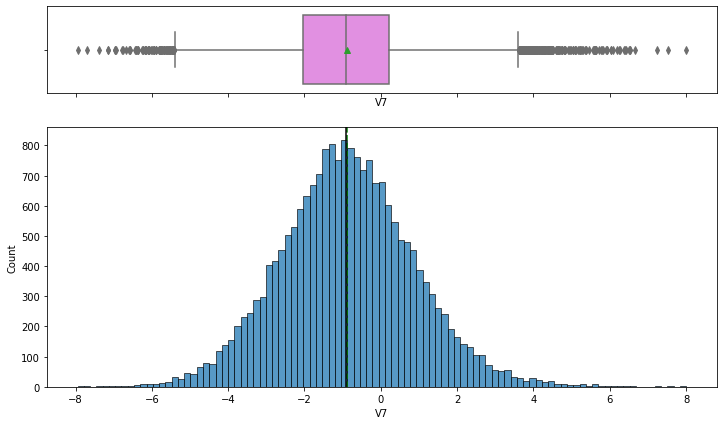

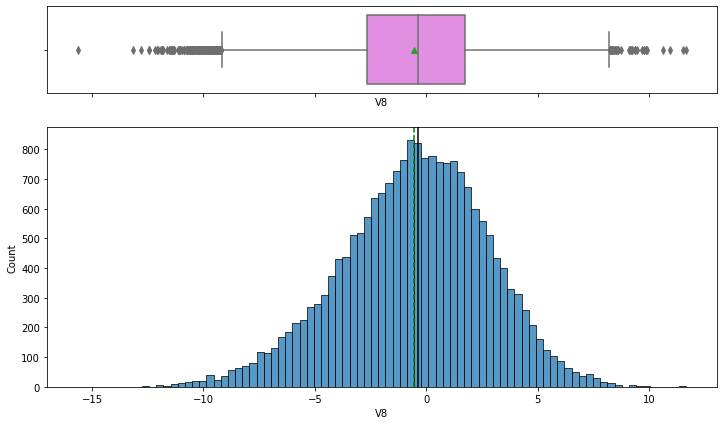

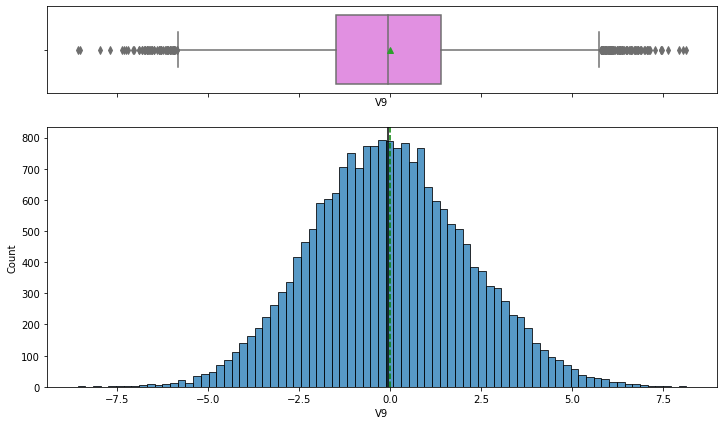

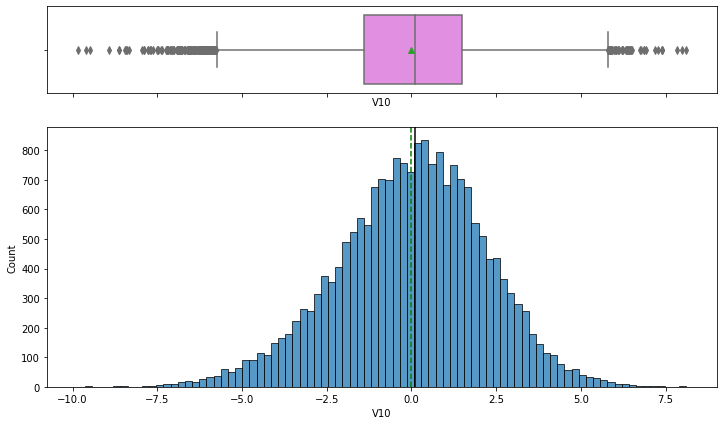

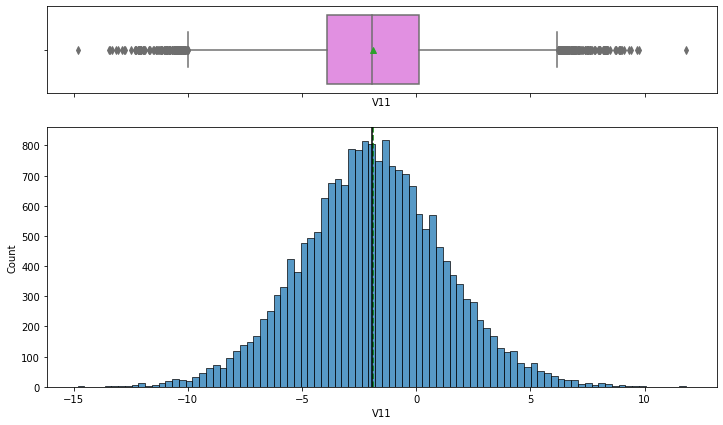

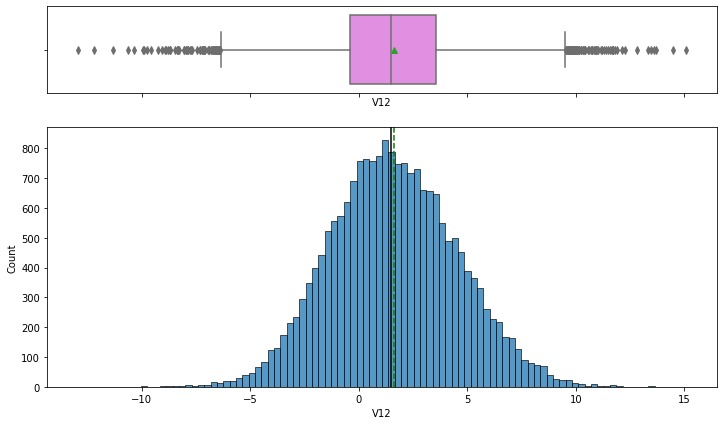

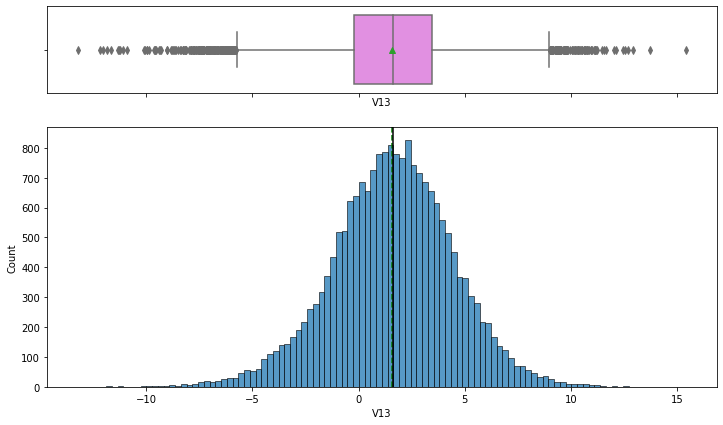

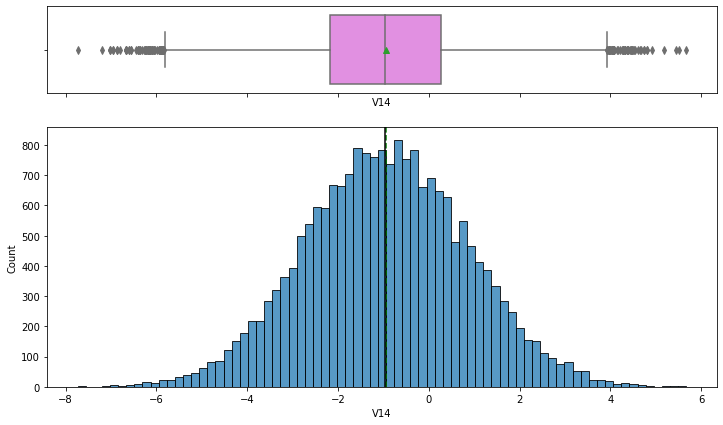

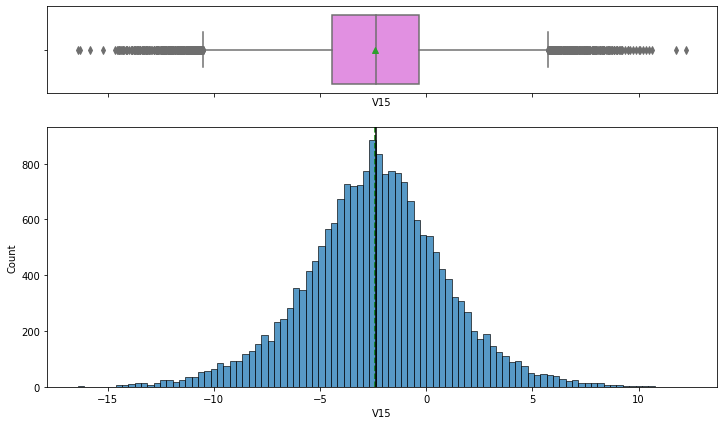

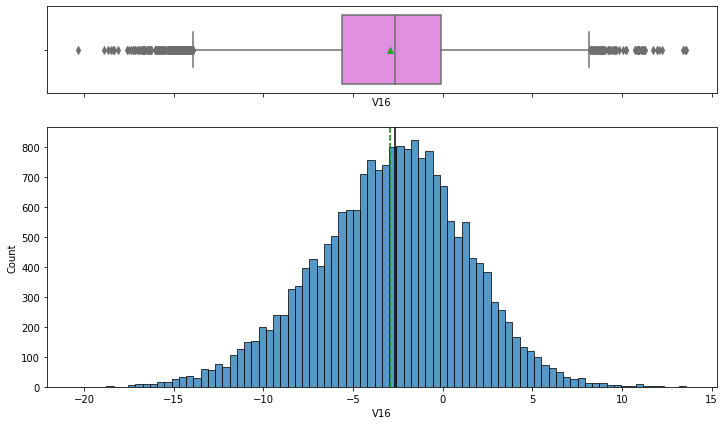

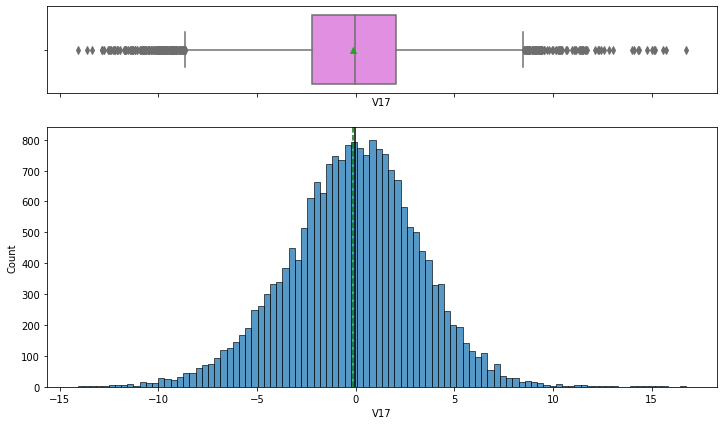

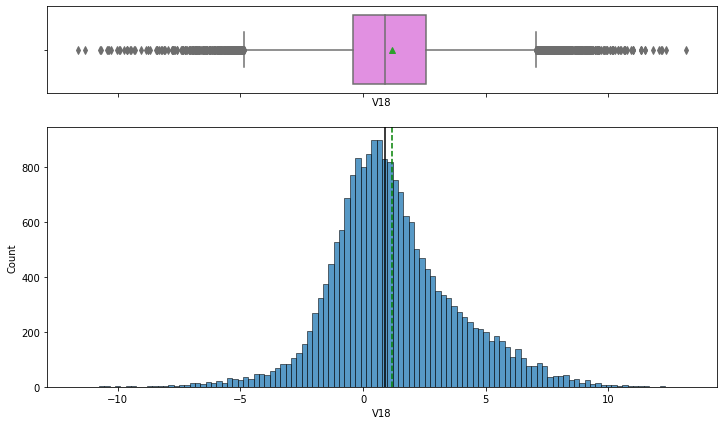

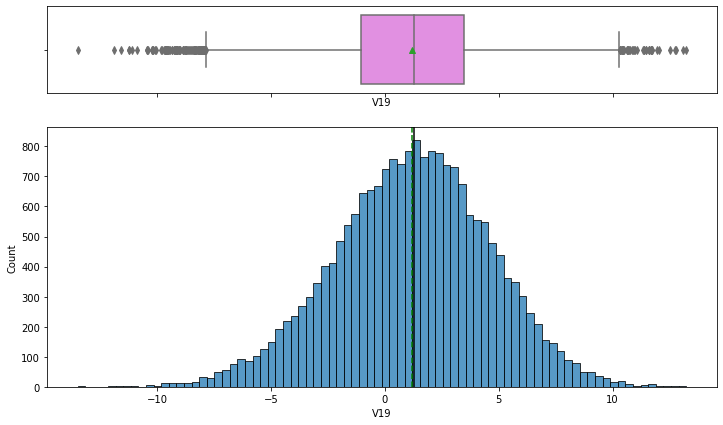

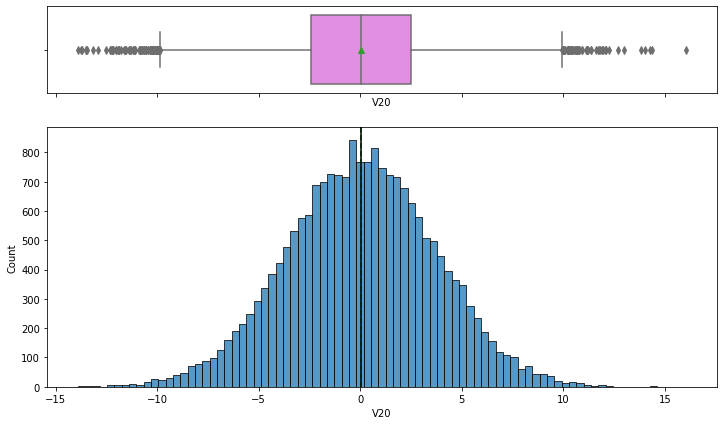

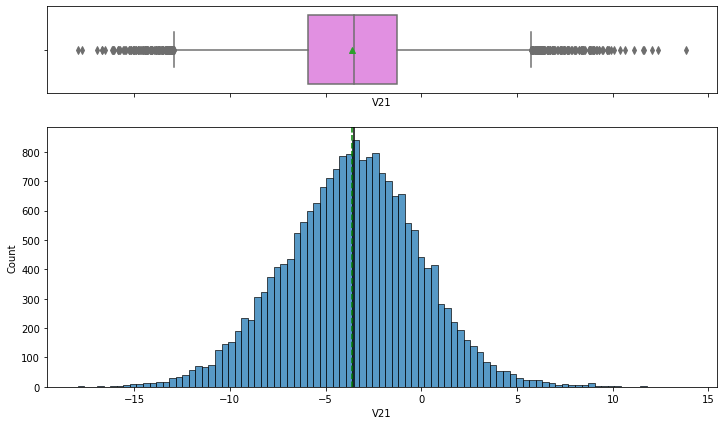

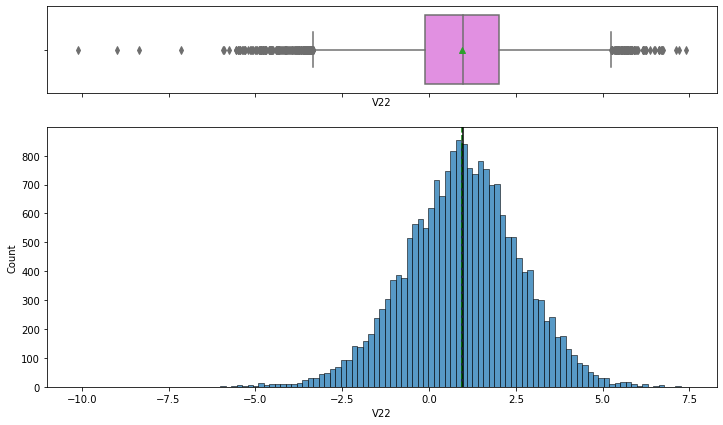

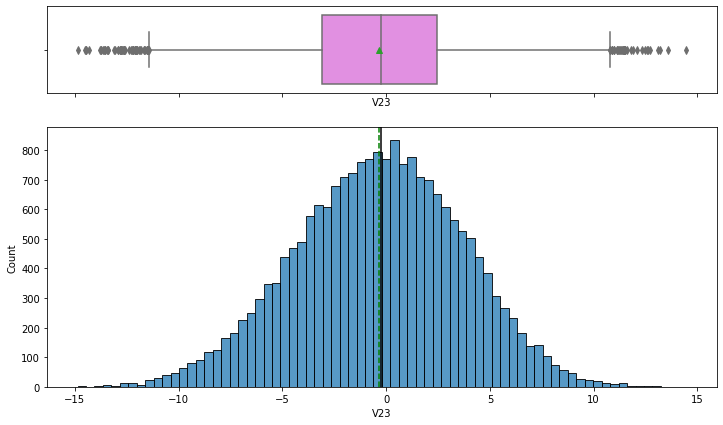

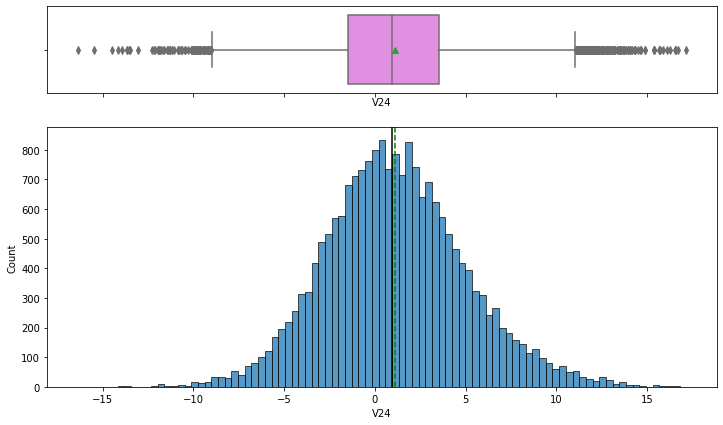

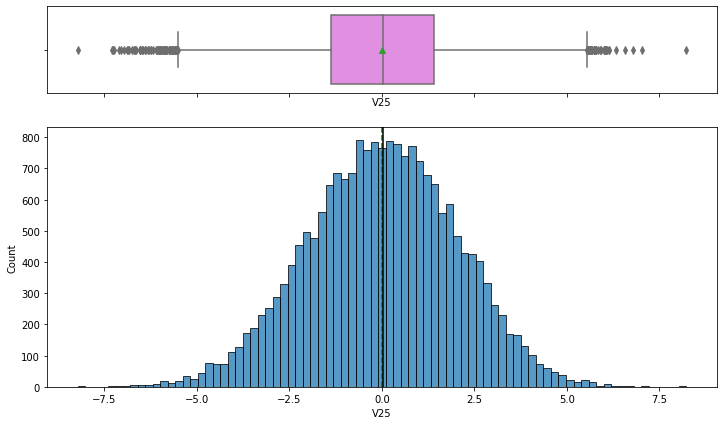

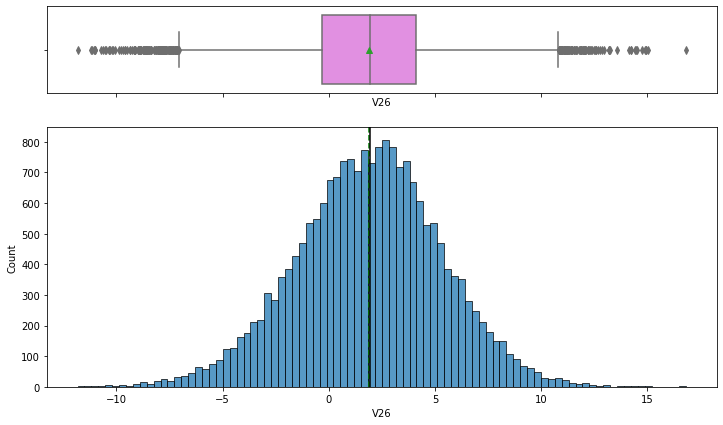

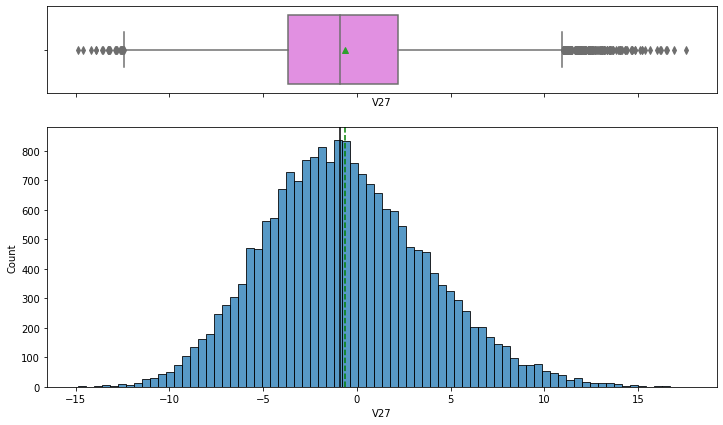

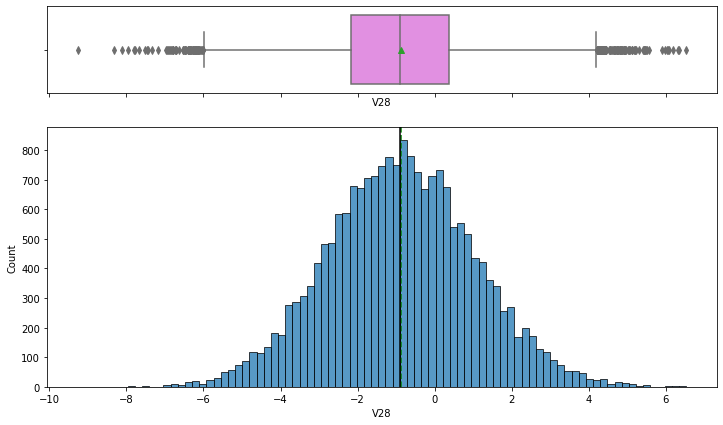

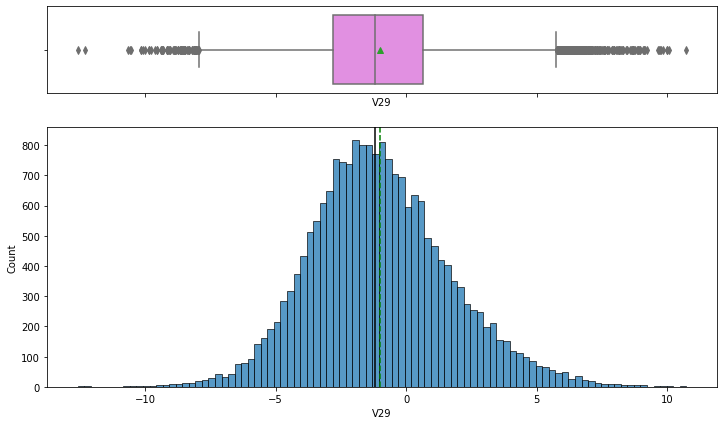

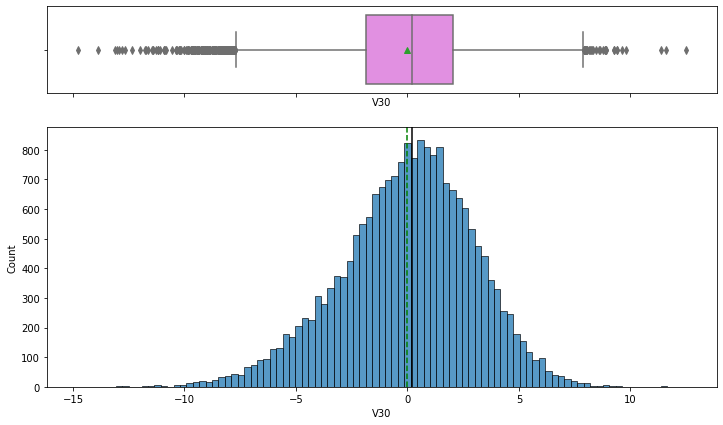

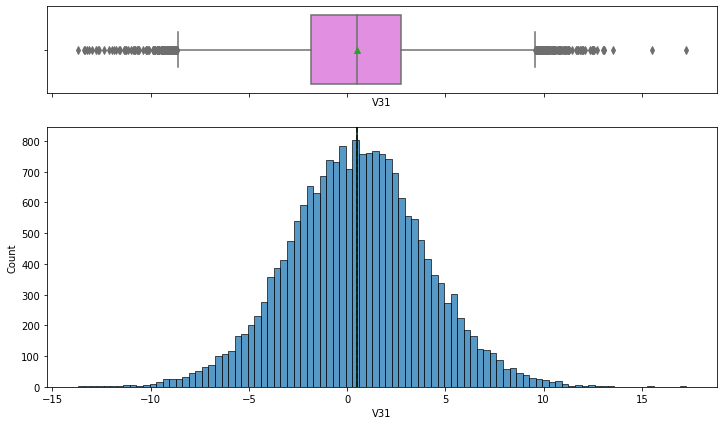

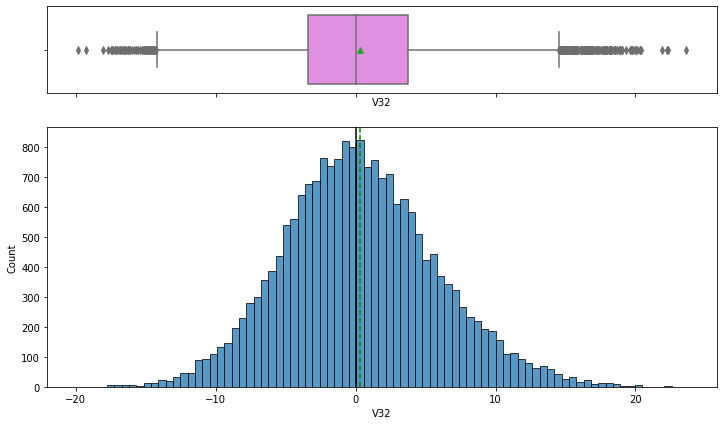

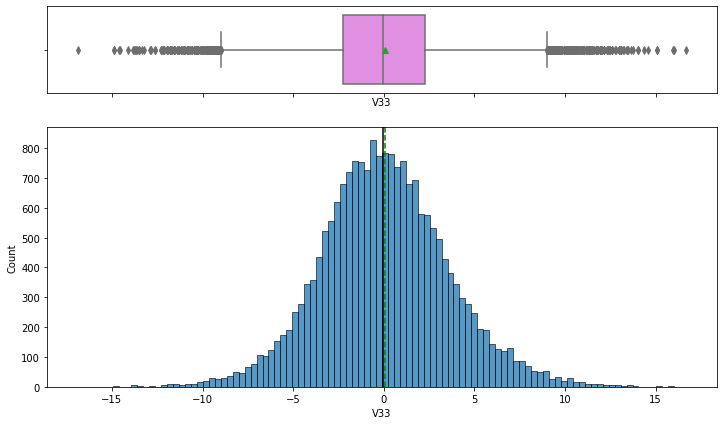

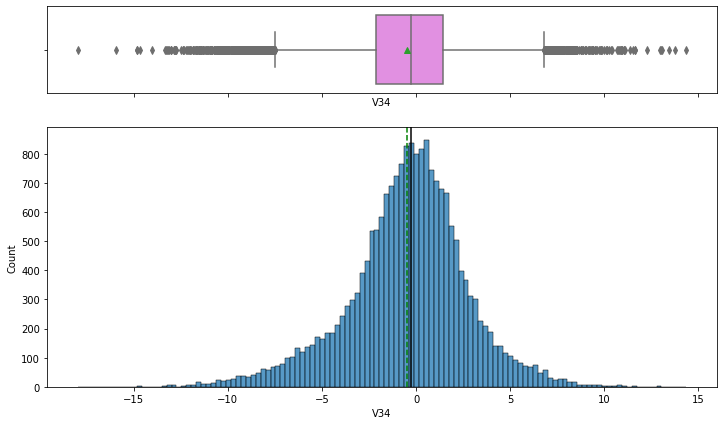

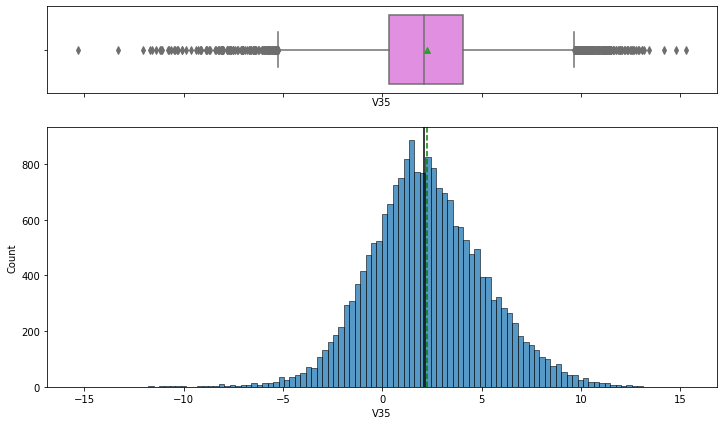

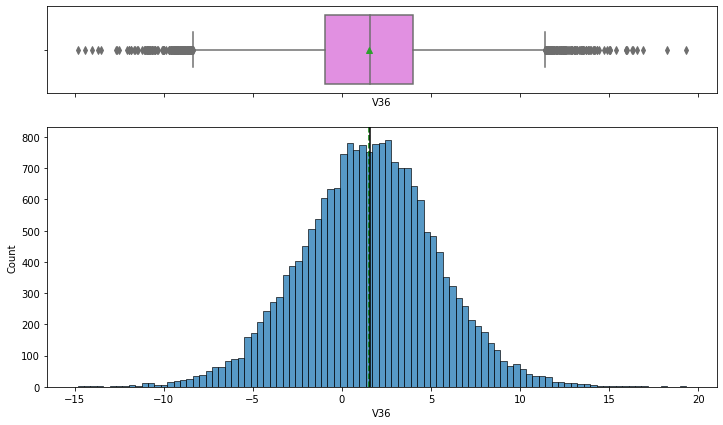

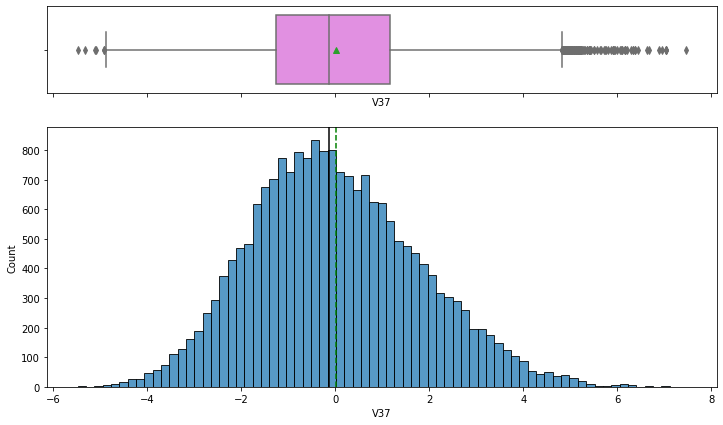

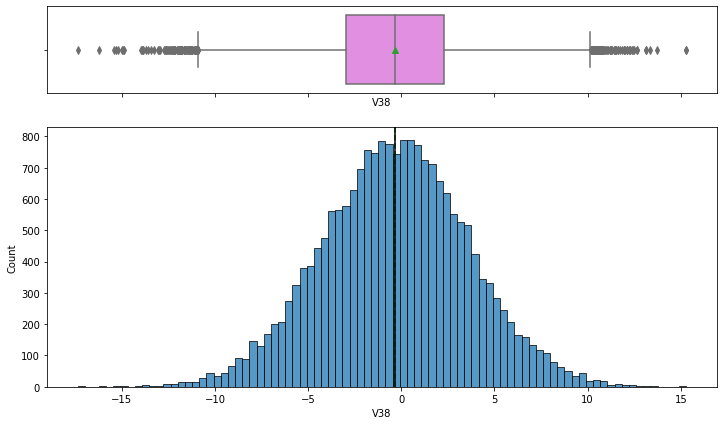

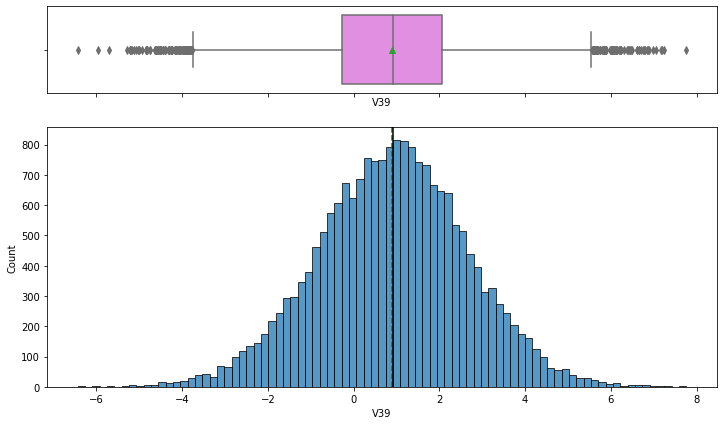

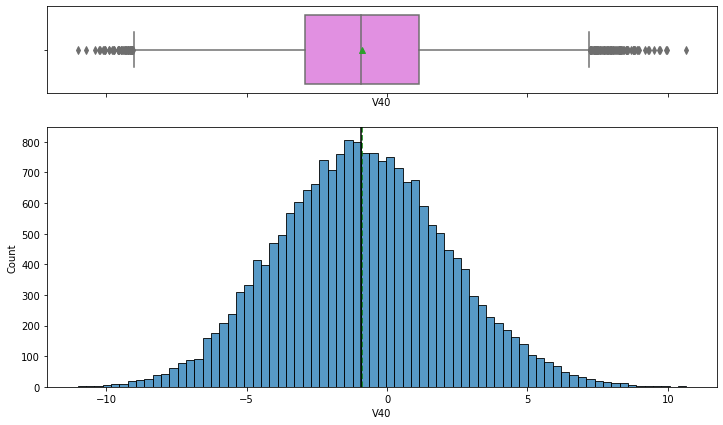

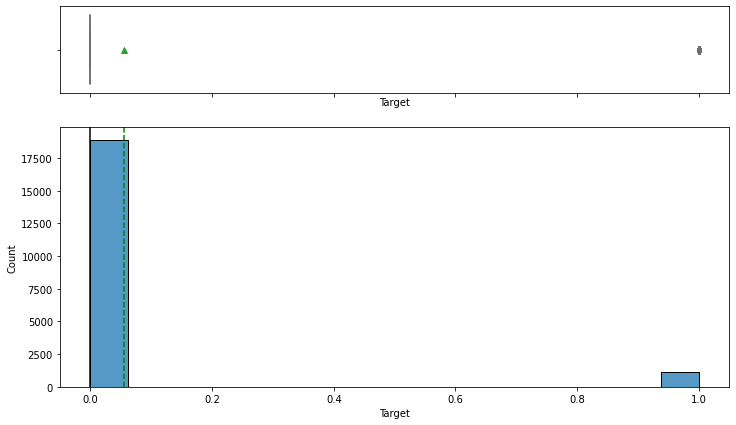

<IPython.core.display.Javascript object>

In [14]:
for feature in df.columns:
    histogram_boxplot(df, feature, figsize=(12, 7), kde=False, bins=None)

- There are positive and negative outliers for all attributes "V1" to "V40". 
- The scale of attributes are more or less the same (somewhere between -15 to +15). 
- Since not much is known about the attributes, the outliers will not be treated and are assumed to be real data trends

## Data Pre-processing

In [15]:
# Splitting the data into X and y
X = df.drop(["Target"], axis=1)
y = df["Target"]

<IPython.core.display.Javascript object>

In [16]:
# Splitting the data into training and validation using train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.30, random_state=1, stratify=y
)
print(X_train.shape, X_val.shape)

(14000, 40) (6000, 40)


<IPython.core.display.Javascript object>

There are 14000 rows in the training and 6000 rows in the validation sets

In [17]:
y_train.value_counts()

0    13223
1      777
Name: Target, dtype: int64

<IPython.core.display.Javascript object>

In [18]:
y_val.value_counts()

0    5667
1     333
Name: Target, dtype: int64

<IPython.core.display.Javascript object>

Stratify has maintained a distribution of approximately 94.12% "No failures" or "0" and 5.88% "Failures" or "1" in both the test and validation splits

## Missing value imputation




In [19]:
# let's create an instace of the imputer to be used
imputer = SimpleImputer(strategy="median")

## Fit the train data
impute = imputer.fit(X_train)

# Transforming the train and validation data
X_train = impute.transform(X_train)
X_val = imputer.transform(X_val)

<IPython.core.display.Javascript object>

## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model. 
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [20]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1},
        index=[0],
    )

    return df_perf

<IPython.core.display.Javascript object>

In [21]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

<IPython.core.display.Javascript object>

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [87]:
# defining metric to be used for optimization and with cross-validation
def Minimum_Vs_Model_cost(y_train, y_pred):

    TP = confusion_matrix(y_train, y_pred)[1, 1]
    FP = confusion_matrix(y_train, y_pred)[0, 1]
    FN = confusion_matrix(y_train, y_pred)[1, 0]
    return ((TP + FN) * 15) / (TP * 15 + FP * 5 + FN * 40)


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

<IPython.core.display.Javascript object>

In [22]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

<IPython.core.display.Javascript object>

### Model Building with original data

Different model building with original data 

In [23]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

models.append(
    ("Logistic Regression", LogisticRegression(solver="newton-cg", random_state=1))
)
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))


Cross-Validation performance on training dataset:

dtree: 0.7078246484698097
Logistic Regression: 0.4902481389578163
Random forest: 0.7194127377998345
Bagging: 0.707808105872622
Adaboost: 0.6434656741108354
GBM: 0.7220016542597187
Xgboost: 0.7979487179487179


<IPython.core.display.Javascript object>

In [24]:
print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Validation Performance:

dtree: 0.7057057057057057
Logistic Regression: 0.5015015015015015
Random forest: 0.7357357357357357
Bagging: 0.7267267267267268
Adaboost: 0.6516516516516516
GBM: 0.7357357357357357
Xgboost: 0.8198198198198198


<IPython.core.display.Javascript object>

The cross validation training performance scores are similar to the validation performance score. This indicates that the default algorithms on original dataset are able to generalize well.

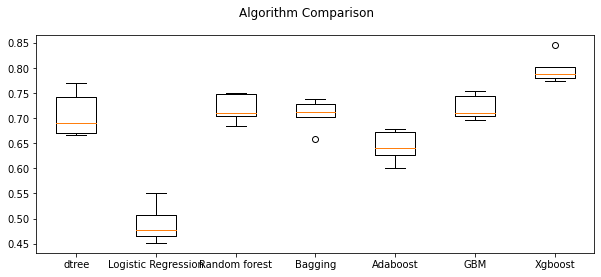

<IPython.core.display.Javascript object>

In [25]:
# Let's plot boxplots for CV scores of all models defined above

fig = plt.figure(figsize=(10, 4))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

- XGBoost (~ 0.79) and Gradient Boosting (~ 0.72) have the best average (& median) training cross validation scores. This is closely followed by the Random Forest Classifier (~ 0.71).
- XGBoost and Bagging classifiers each have one outlier as can be observed from the boxplot.

### Model Building with Oversampled data


In [26]:
print(
    "Before Oversampling, counts of label '1 (Failures)': {}".format(sum(y_train == 1))
)
print(
    "Before Oversampling, counts of label '0 (No failures)': {} \n".format(
        sum(y_train == 0)
    )
)

Before Oversampling, counts of label '1 (Failures)': 777
Before Oversampling, counts of label '0 (No failures)': 13223 



<IPython.core.display.Javascript object>

In [27]:
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

<IPython.core.display.Javascript object>

In [28]:
print(
    "After Oversampling, counts of label '1 (Failures)': {}".format(
        sum(y_train_over == 1)
    )
)
print(
    "After Oversampling, counts of label '0 (No failures)': {} \n".format(
        sum(y_train_over == 0)
    )
)

After Oversampling, counts of label '1 (Failures)': 13223
After Oversampling, counts of label '0 (No failures)': 13223 



<IPython.core.display.Javascript object>

- To handle class imbalance in the "Target" attribute, synthetic minority oversampling technique is employed to generate synthetic data points for minority class of importance (i.e, class "1" or No failures)
- After applying SMOTE, we have equal number of class "1" and class "0" target outcomes

In [29]:
models_over = []  # Empty list to store all the models

# Appending models into the list
models_over.append(("dtree", DecisionTreeClassifier(random_state=1)))

models_over.append(
    ("Logistic Regression", LogisticRegression(solver="newton-cg", random_state=1))
)
models_over.append(("Random forest", RandomForestClassifier(random_state=1)))
models_over.append(("Bagging", BaggingClassifier(random_state=1)))
models_over.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models_over.append(("GBM", GradientBoostingClassifier(random_state=1)))
models_over.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results_over = []  # Empty list to store all model's CV scores
names_over = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models_over:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results_over.append(cv_result)
    names_over.append(name)
    print("{}: {}".format(name, cv_result.mean()))


Cross-Validation performance on training dataset:

dtree: 0.970128321355339
Logistic Regression: 0.8917800548518742
Random forest: 0.9829090368319754
Bagging: 0.975119441528989
Adaboost: 0.904787470436327
GBM: 0.9329201902370526
Xgboost: 0.9895639018614746


<IPython.core.display.Javascript object>

In [30]:
print("\n" "Validation Performance:" "\n")

for name, model in models_over:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Validation Performance:

dtree: 0.7837837837837838
Logistic Regression: 0.8498498498498499
Random forest: 0.8558558558558559
Bagging: 0.8258258258258259
Adaboost: 0.8618618618618619
GBM: 0.8768768768768769
Xgboost: 0.8558558558558559


<IPython.core.display.Javascript object>

The cross validation training performance scores are much higher than validation perfromance score.

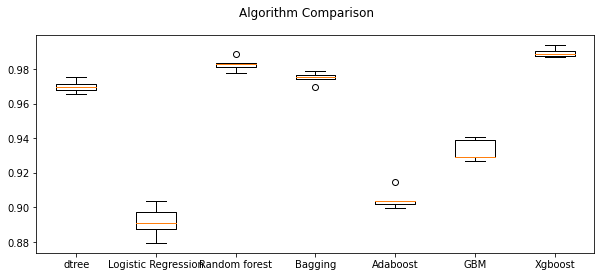

<IPython.core.display.Javascript object>

In [31]:
# Plotting boxplots for CV scores of all models defined above

fig = plt.figure(figsize=(10, 4))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results_over)
ax.set_xticklabels(names)

plt.show()

### Model Building with Undersampled data

In [32]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_und, y_train_und = rus.fit_resample(X_train, y_train)

<IPython.core.display.Javascript object>

In [33]:
print(
    "After Undersampling, counts of label '1 (Failures)': {}".format(
        sum(y_train_und == 1)
    )
)
print(
    "After Undersampling, counts of label '0 (No failures)': {} \n".format(
        sum(y_train_und == 0)
    )
)

After Undersampling, counts of label '1 (Failures)': 777
After Undersampling, counts of label '0 (No failures)': 777 



<IPython.core.display.Javascript object>

- random undersampling is a technique used to handle class imbalance where only random samples from the majority class are chosen for model building. While this technique helps in dealing with models potentially overfitting, it can often lead to poor performing models due to "loss of information" from not considering all datapoints available. 
- After performing random undersampling, we obtain equal number of class "1" (777) and class "0" (777). Overall, we have less number of datapoints for model building.

In [34]:
models_und = []  # Empty list to store all the models

# Appending models into the list

models_und.append(("dtree", DecisionTreeClassifier(random_state=1)))
models_und.append(
    ("Logistic Regression", LogisticRegression(solver="newton-cg", random_state=1))
)
models_und.append(("Random forest", RandomForestClassifier(random_state=1)))
models_und.append(("Bagging", BaggingClassifier(random_state=1)))
models_und.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models_und.append(("GBM", GradientBoostingClassifier(random_state=1)))
models_und.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results_und = []  # Empty list to store all model's CV scores
names_und = []  # Empty list to store name of the models

# loop through all models to get the mean cross validated score

print("\n" "Cross-Validation Performance:" "\n")

for name, model in models_und:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_und, y=y_train_und, scoring=scorer, cv=kfold
    )
    results_und.append(cv_result)
    names_und.append(name)
    print("{}: {}".format(name, cv_result.mean()))


Cross-Validation Performance:

dtree: 0.8622167080231596
Logistic Regression: 0.8726220016542598
Random forest: 0.9034822167080232
Bagging: 0.880339123242349
Adaboost: 0.8725971877584782
GBM: 0.8932009925558313
Xgboost: 0.897055417700579


<IPython.core.display.Javascript object>

In [35]:
print("\n" "Validation Performance:" "\n")

for name, model in models_und:
    model.fit(X_train_und, y_train_und)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Validation Performance:

dtree: 0.8408408408408409
Logistic Regression: 0.8468468468468469
Random forest: 0.8828828828828829
Bagging: 0.8708708708708709
Adaboost: 0.8588588588588588
GBM: 0.8828828828828829
Xgboost: 0.8918918918918919


<IPython.core.display.Javascript object>

The performance scores for the training and validation undersampled dataset seem to be almost similar. This could be likely that we have less number of datapoints for model building. This will again be a concern taking these models to production.

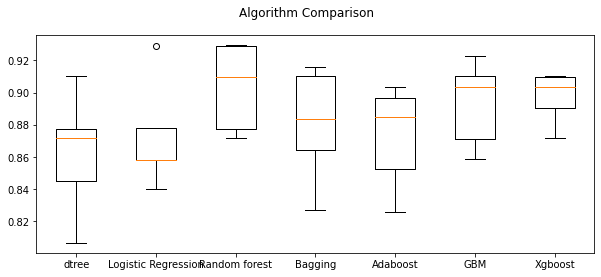

<IPython.core.display.Javascript object>

In [36]:
# Plotting boxplots for CV scores of all models defined above

fig = plt.figure(figsize=(10, 4))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results_und)
ax.set_xticklabels(names)

plt.show()

The algorithms are able to give better performance on the cross validation training scores on undersampled dataset in comparison to original dataset as can be seen from the boxplots.

## HyperparameterTuning 

### Sample Parameter Grids

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

- For Gradient Boosting:

param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7], 
    "max_features":[0.5,0.7]
}

- For Adaboost:

param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

- For Bagging Classifier:

param_grid = {
    'max_samples': [0.8,0.9,1], 
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}

- For Random Forest:

param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

- For Decision Trees:

param_grid = {
    'max_depth': np.arange(2,6), 
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}

- For Logistic Regression:

param_grid = {'C': np.arange(0.1,1.1,0.1)}

- For XGBoost:

param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

### Note

- Models built on original dataset have given generalized performance on cross validation training and validation sets unlike models built on oversampled or undersampled sets.
- Mean cross validation scores on training sets are highest with XGBoost, Random Forest & Gradient Boost Classifiers. These models will be tuned further to try to increase performance.

### 1. Tuning method for Decision tree with original data

In [37]:
# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "max_depth": np.arange(2, 6),
    "min_samples_leaf": [1, 4, 7],
    "max_leaf_nodes": [10, 15],
    "min_impurity_decrease": [0.0001, 0.001],
}

# Running the randomized search
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=10,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

Best parameters are {'min_samples_leaf': 7, 'min_impurity_decrease': 0.0001, 'max_leaf_nodes': 15, 'max_depth': 5} with CV score=0.550752688172043:


<IPython.core.display.Javascript object>

### Tuning method for Decision tree with oversampled data

In [38]:
# defining model
model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "max_depth": np.arange(2, 6),
    "min_samples_leaf": [1, 4, 7],
    "max_leaf_nodes": [10, 15],
    "min_impurity_decrease": [0.0001, 0.001],
}

# Running the randomized search
randomized_cv = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=10,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

Best parameters are {'min_samples_leaf': 7, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 15, 'max_depth': 3} with CV score=0.9240715362242579:


<IPython.core.display.Javascript object>

### Tuning method for Decision tree with undersampled data

In [39]:
# defining model
model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "max_depth": np.arange(2, 20),
    "min_samples_leaf": [1, 2, 5, 7],
    "max_leaf_nodes": [5, 10, 15],
    "min_impurity_decrease": [0.0001, 0.001],
}

# Running the randomized search
randomized_cv = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=10,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_und, y_train_und)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

Best parameters are {'min_samples_leaf': 1, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 15, 'max_depth': 11} with CV score=0.83520264681555:


<IPython.core.display.Javascript object>

### 2. XGBoost Hyperparameter Tuning with Original Data

In [40]:
# XGBoost Hyperparameter Tuning
model1 = XGBClassifier(random_state=1, eval_metric="logloss")

# Parameter grid to pass in RandomizedSearchCV
param_grid1 = {
    "n_estimators": np.arange(150, 200, 250),
    "scale_pos_weight": [5, 10],
    "learning_rate": [0.1, 0.2],
    "gamma": [0, 3, 5],
    "subsample": [0.8, 0.9],
}

# Running the randomized search
randomized_cv1 = RandomizedSearchCV(
    estimator=model1,
    param_distributions=param_grid1,
    n_iter=10,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv1.fit(X_train, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv1.best_params_, randomized_cv1.best_score_
    )
)

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 150, 'learning_rate': 0.1, 'gamma': 5} with CV score=0.8546236559139784:


<IPython.core.display.Javascript object>

The best hyperparameters using RandomizedSearch CV for XGBoost model were found to be: n_estimators 150, subsample 0.9, learning_rate 0.1, gamma 5.

In [41]:
# building model with best parameters
xgb_tuned = XGBClassifier(
    subsample=0.9,
    scale_pos_weight=10,
    n_estimators=150,
    learning_rate=0.1,
    gamma=5,
    random_state=1,
    eval_metric="logloss",
)

# Fit the model on training data
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1, reg_alpha=0, reg_lambda=1, ...)

<IPython.core.display.Javascript object>

Training performance 
    Accuracy  Recall  Precision    F1
0     0.999   1.000      0.982 0.991
Validation performance 
    Accuracy  Recall  Precision    F1
0     0.989   0.853      0.934 0.892


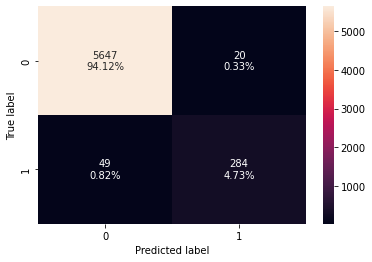

<IPython.core.display.Javascript object>

In [49]:
# Calculating different metrics
xgboost_random_train = model_performance_classification_sklearn(
    xgb_tuned, X_train, y_train
)
print("Training performance \n", xgboost_random_train)

xgboost_random_val = model_performance_classification_sklearn(xgb_tuned, X_val, y_val)
print("Validation performance \n", xgboost_random_val)

# create a confusion matrix of the classifier's performance on the validation data
confusion_matrix_sklearn(xgb_tuned, X_val, y_val)

### Tuning method for XGBClassifier with oversampled data

In [50]:
# XGBoost Hyperparameter Tuning
model1 = XGBClassifier(random_state=1, eval_metric="logloss")

# Parameter grid to pass in RandomizedSearchCV
param_grid1 = {
    "n_estimators": np.arange(150, 200, 250),
    "scale_pos_weight": [5, 10],
    "learning_rate": [0.1, 0.2],
    "gamma": [0, 3, 5],
    "subsample": [0.8, 0.9],
}

# Running the randomized search
randomized_cv1 = RandomizedSearchCV(
    estimator=model1,
    param_distributions=param_grid1,
    n_iter=10,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv1.fit(X_train_over, y_train_over)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv1.best_params_, randomized_cv1.best_score_
    )
)

Best parameters are {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 150, 'learning_rate': 0.1, 'gamma': 5} with CV score=0.9960671091803963:


<IPython.core.display.Javascript object>

### Tuning method for XGBClassifier with undersampled data

In [51]:
# XGBoost Hyperparameter Tuning
model1 = XGBClassifier(random_state=1, eval_metric="logloss")

# Parameter grid to pass in RandomizedSearchCV
param_grid1 = {
    "n_estimators": np.arange(150, 200, 250),
    "scale_pos_weight": [5, 10],
    "learning_rate": [0.1, 0.2],
    "gamma": [0, 3, 5],
    "subsample": [0.8, 0.9],
}

# Running the randomized search
randomized_cv1 = RandomizedSearchCV(
    estimator=model1,
    param_distributions=param_grid1,
    n_iter=10,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv1.fit(X_train_und, y_train_und)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv1.best_params_, randomized_cv1.best_score_
    )
)

Best parameters are {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 150, 'learning_rate': 0.1, 'gamma': 5} with CV score=0.9291976840363937:


<IPython.core.display.Javascript object>

### 3. Random Forest Hyperparameter Tuning with Original Data

In [52]:
model2 = RandomForestClassifier(random_state=1)

# Grid of parameters to choose from
param_grid2 = {
    "n_estimators": [200, 250, 300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1), "sqrt"],
    "max_samples": np.arange(0.4, 0.7, 0.1),
}

# Running the randomized search
randomized_cv2 = RandomizedSearchCV(
    estimator=model2,
    param_distributions=param_grid2,
    n_iter=10,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv2.fit(X_train, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv2.best_params_, randomized_cv2.best_score_
    )
)

Best parameters are {'n_estimators': 250, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.6950620347394542:


<IPython.core.display.Javascript object>

The best hyperparameters using RandomizedSearch CV for the Random Forest Classifier were found to be: n_estimators 250, max_samples 0.6, max_features 'sqrt', min_sample_leaf 1.

In [53]:
# building model with best parameters
rf_tuned = RandomForestClassifier(
    n_estimators=250,
    min_samples_leaf=1,
    max_samples=0.6,
    max_features="sqrt",
    random_state=1,
)

# Fit the model on training data
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(max_samples=0.6, n_estimators=250, random_state=1)

<IPython.core.display.Javascript object>

Training performance 
    Accuracy  Recall  Precision    F1
0     0.995   0.910      1.000 0.953
Validation performance 
    Accuracy  Recall  Precision    F1
0     0.984   0.721      0.988 0.833


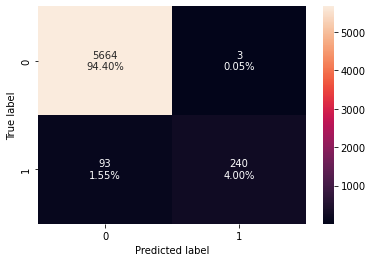

<IPython.core.display.Javascript object>

In [54]:
# Calculating different metrics
rf_random_train = model_performance_classification_sklearn(rf_tuned, X_train, y_train)
print("Training performance \n", rf_random_train)

rf_random_val = model_performance_classification_sklearn(rf_tuned, X_val, y_val)
print("Validation performance \n", rf_random_val)

# create a confusion matrix of the classifier's performance on the validation data
confusion_matrix_sklearn(rf_tuned, X_val, y_val)

### Tuning method for Random Forest with oversampled data

In [55]:
model2 = RandomForestClassifier(random_state=1)

param_grid2 = {
    "n_estimators": [200, 250, 300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1), "sqrt"],
    "max_samples": np.arange(0.4, 0.7, 0.1),
}

# Running the randomized search
randomized_cv2 = RandomizedSearchCV(
    estimator=model2,
    param_distributions=param_grid2,
    n_iter=10,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv2.fit(X_train_over, y_train_over)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv2.best_params_, randomized_cv2.best_score_
    )
)

Best parameters are {'n_estimators': 250, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.9815469200872826:


<IPython.core.display.Javascript object>

### Tuning method for Random Forest with undersampled data

In [56]:
model2 = RandomForestClassifier(random_state=1)

param_grid2 = {
    "n_estimators": [200, 250, 300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1), "sqrt"],
    "max_samples": np.arange(0.4, 0.7, 0.1),
}

# Running the randomized search
randomized_cv2 = RandomizedSearchCV(
    estimator=model2,
    param_distributions=param_grid2,
    n_iter=10,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv2.fit(X_train_und, y_train_und)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv2.best_params_, randomized_cv2.best_score_
    )
)

Best parameters are {'n_estimators': 300, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.9047477253928868:


<IPython.core.display.Javascript object>

### 4. Gradient Boosting Classifier Hyperparameter Tuning with Original Data

In [57]:
# Choose the type of classifier.
model3 = GradientBoostingClassifier(random_state=1)

# Grid of parameters to choose from
param_grid3 = {
    "n_estimators": np.arange(100, 150, 25),
    "subsample": [0.5, 0.7],
    "max_features": [0.5, 0.7],
    "learning_rate": [0.2, 0.05, 1],
}

# Running the randomized search
randomized_cv3 = RandomizedSearchCV(
    estimator=model3,
    param_distributions=param_grid3,
    n_iter=10,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv3.fit(X_train, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv3.best_params_, randomized_cv3.best_score_
    )
)

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 0.2} with CV score=0.7348966087675766:


<IPython.core.display.Javascript object>

The best hyperparameters using RandomizedSearch CV for Gradient Boosting Classifier were found to be: n_estimator 125, max_features 0.5, subsample 0.7.

In [59]:
# Building model with best parameters
gbc_tuned = GradientBoostingClassifier(
    n_estimators=125,
    subsample=0.7,
    max_features=0.5,
    learning_rate=0.2,
    random_state=1,
)

# Fit the model on training data
gbc_tuned.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.5,
                           n_estimators=125, random_state=1, subsample=0.7)

<IPython.core.display.Javascript object>

Training performance 
    Accuracy  Recall  Precision    F1
0     0.996   0.925      0.993 0.958
Validation performance 
    Accuracy  Recall  Precision    F1
0     0.982   0.763      0.898 0.825


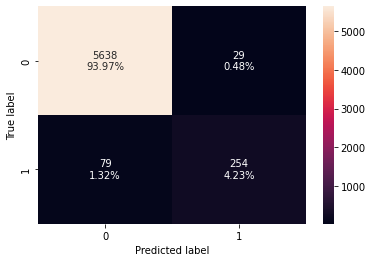

<IPython.core.display.Javascript object>

In [60]:
# Calculating different metrics
gbc_random_train = model_performance_classification_sklearn(gbc_tuned, X_train, y_train)
print("Training performance \n", gbc_random_train)

gbc_random_val = model_performance_classification_sklearn(gbc_tuned, X_val, y_val)
print("Validation performance \n", gbc_random_val)

# create a confusion matrix of the classifier's performance on the validation data
confusion_matrix_sklearn(gbc_tuned, X_val, y_val)

### Gradient Boosting Classifier Hyperparameter Tuning with Oversampled Data

In [61]:
# Choose the type of classifier.
model3 = GradientBoostingClassifier(random_state=1)

# Grid of parameters to choose from
param_grid3 = {
    "n_estimators": np.arange(100, 150, 25),
    "subsample": [0.5, 0.7],
    "max_features": [0.5, 0.7],
    "learning_rate": [0.2, 0.05, 1],
}

# Running the randomized search
randomized_cv3 = RandomizedSearchCV(
    estimator=model3,
    param_distributions=param_grid3,
    n_iter=10,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv3.fit(X_train_over, y_train_over)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv3.best_params_, randomized_cv3.best_score_
    )
)

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 1} with CV score=0.9712619934852675:


<IPython.core.display.Javascript object>

### Gradient Boosting Classifier Hyperparameter Tuning with Undersampled Data

In [62]:
# Choose the type of classifier.
model3 = GradientBoostingClassifier(random_state=1)

# Grid of parameters to choose from
param_grid3 = {
    "n_estimators": np.arange(100, 150, 25),
    "subsample": [0.5, 0.7],
    "max_features": [0.5, 0.7],
    "learning_rate": [0.2, 0.05, 1],
}

# Running the randomized search
randomized_cv3 = RandomizedSearchCV(
    estimator=model3,
    param_distributions=param_grid3,
    n_iter=10,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv3.fit(X_train_und, y_train_und)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv3.best_params_, randomized_cv3.best_score_
    )
)

Best parameters are {'subsample': 0.7, 'n_estimators': 100, 'max_features': 0.7, 'learning_rate': 0.05} with CV score=0.9047394540942928:


<IPython.core.display.Javascript object>

## Model performance comparison and choosing the final model

In [63]:
# Training performance comparison

models_train_comp_df = pd.concat(
    [
        xgboost_random_train.T,
        rf_random_train.T,
        gbc_random_train.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "XGBoost Tuned with Random search",
    "Random forest Tuned with Random search",
    "Gradient Boost Tuned with Random Search",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,XGBoost Tuned with Random search,Random forest Tuned with Random search,Gradient Boost Tuned with Random Search
Accuracy,0.999,0.995,0.996
Recall,1.000,0.910,0.925
Precision,0.982,1.000,0.993
F1,0.991,0.953,0.958


<IPython.core.display.Javascript object>

In [64]:
# Validation performance comparison

models_val_comp_df = pd.concat(
    [
        xgboost_random_val.T,
        rf_random_val.T,
        gbc_random_val.T,
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "XGBoost Tuned with Random search",
    "Random forest Tuned with Random search",
    "Gradient Boost Tuned with Random Search",
]
print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,XGBoost Tuned with Random search,Random forest Tuned with Random search,Gradient Boost Tuned with Random Search
Accuracy,0.989,0.984,0.982
Recall,0.853,0.721,0.763
Precision,0.934,0.988,0.898
F1,0.892,0.833,0.825


<IPython.core.display.Javascript object>

- The XGBoost Tuned model with Random Search is giving the highest performance score on the validation set.
- We will choose this tuned model to see if it can generalize well on the testing dataset to give a likewise high performance score.

### Test set final performance

In [65]:
# Let's load the test dataset
test = pd.read_csv("Test.csv")

<IPython.core.display.Javascript object>

In [66]:
X_test = test.drop(["Target"], axis=1)
y_test = test["Target"]

<IPython.core.display.Javascript object>

In [67]:
y_test.value_counts()

0    4718
1     282
Name: Target, dtype: int64

<IPython.core.display.Javascript object>

In [68]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 40 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      4995 non-null   float64
 1   V2      4994 non-null   float64
 2   V3      5000 non-null   float64
 3   V4      5000 non-null   float64
 4   V5      5000 non-null   float64
 5   V6      5000 non-null   float64
 6   V7      5000 non-null   float64
 7   V8      5000 non-null   float64
 8   V9      5000 non-null   float64
 9   V10     5000 non-null   float64
 10  V11     5000 non-null   float64
 11  V12     5000 non-null   float64
 12  V13     5000 non-null   float64
 13  V14     5000 non-null   float64
 14  V15     5000 non-null   float64
 15  V16     5000 non-null   float64
 16  V17     5000 non-null   float64
 17  V18     5000 non-null   float64
 18  V19     5000 non-null   float64
 19  V20     5000 non-null   float64
 20  V21     5000 non-null   float64
 21  V22     5000 non-null   float64
 22  

<IPython.core.display.Javascript object>

There are 5 & 6 missing values for attributes "V1" and "V2" respectively.

In [69]:
imputer = SimpleImputer(strategy="median")
impute = imputer.fit(X_test)
X_test = imputer.transform(X_test)

<IPython.core.display.Javascript object>

In [88]:
print("\n" "Test Performance:" "\n")

final_model = XGBClassifier(
    subsample=0.9,
    scale_pos_weight=10,
    n_estimators=150,
    learning_rate=0.1,
    gamma=5,
    random_state=1,
    eval_metric="logloss",
)

name = "XGboost_tuned"

final_model.fit(X_train, y_train)
final_scores = Minimum_Vs_Model_cost(y_test, final_model.predict(X_test))
print("{}: {}".format(name, final_scores))


Test Performance:

XGboost_tuned: 0.7718978102189781


<IPython.core.display.Javascript object>

In [72]:
xgboost_test = model_performance_classification_sklearn(final_model, X_test, y_test)
xgboost_test

,Accuracy,Recall,Precision,F1
0,0.987,0.837,0.922,0.877


<IPython.core.display.Javascript object>

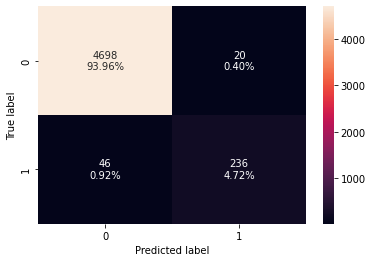

<IPython.core.display.Javascript object>

In [73]:
# Let's create a confusion matrix
confusion_matrix_sklearn(final_model, X_test, y_test)

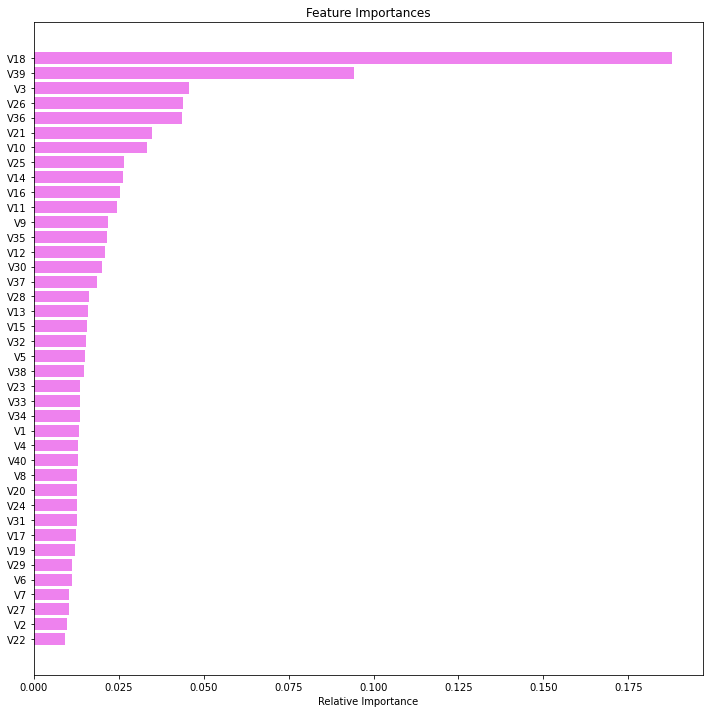

<IPython.core.display.Javascript object>

In [74]:
feature_names = df.columns
importances = final_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

The top five attributes that have the maximum importance for making accurate failure/ no-failure predictions are "V18", "V39", "V26", "V3" & "V10"

## Pipelines to build the final model


Pipelines can be used to put the final model in production

In [75]:
# In the final model, we will not be splitting train set into train and validation sets

X_train_pipeline = train.drop("Target", axis=1)
y_train_pipeline = train["Target"]

<IPython.core.display.Javascript object>

In [76]:
X_test_pipeline = test.drop("Target", axis=1)
y_test_pipeline = test["Target"]

<IPython.core.display.Javascript object>

In [77]:
model_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        (
            "XGB",
            XGBClassifier(
                subsample=0.9,
                scale_pos_weight=10,
                n_estimators=250,
                learning_rate=0.1,
                gamma=3,
                random_state=1,
                eval_metric="logloss",
            ),
        ),
    ]
)
# Fit the model on training data
model_pipeline.fit(X_train_pipeline, y_train_pipeline)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               gamma=3, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.1, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=250, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=1, reg_alpha=0,
                               reg_lambda=1, ...))])

<IPython.core.display.Javascript object>

In [78]:
# transforming and predicting on test data
model_pipeline.predict(X_test_pipeline)

array([0, 0, 0, ..., 0, 0, 0])

<IPython.core.display.Javascript object>

In [89]:
Minimum_Vs_Model_cost(y_test_pipeline, model_pipeline.predict(X_test_pipeline))

0.7761467889908257

<IPython.core.display.Javascript object>

The pipeline performance is as expected (0.776) indicating that it was built accurately to replicate the final chosen model after necessary pre processing.

# Business Insights and Conclusions

### 1. Conclusions

- Seven different machine learning algorithms were fit on original training dataset: Logistic Regression, Decision Tree, Random Forest, Bagging Classifier, and Boosting Classifiers (AdaBoost, Gradient Boost, XGBoost).
- The class imbalance in the dataset was handled by Synthetic Minority Oversampling Technique (SMOTE) and Random Under sampler.

### 2. Business Insights

- A machine learning model has been built to minimize the total maintenance cost of machinery/processes used for wind energy production.

- The final tuned model (XGBoost) was chosen after building ~7 different machine learning algorithms & further optimizing for target class imbalance (having few "failures" and many "no failures" in dataset) as well as finetuning the algorithm performance (hyperparameter and cross validation techniques)

- A pipeline was additionally built to productionise the final chosen model.

- The model is expected to generalize well in terms of predictions & expected to result in a minimum possible maintenance cost. Having no model in place for predictions could potentially result in very high costs as far as replacements and maintenance is concerned. Thus, productionizing the model has a large cost saving advantage.

- The main attributes of importance for predicting failures vs. no failures were found to be "V18", "V39", "V3", "V26" & "V36" in order of decreasing importance. This added knowledge can be used to refine the process of collecting more frequent sensor information to be used in improving the machine learning model to further decrease maintenance costs.

***